In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [3]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [5]:
from sklearn.ensemble import BaggingClassifier

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [7]:
pd.options.display.float_format = '{:.2f}'.format

In [8]:
df = pd.read_csv("final.csv")
df.drop(columns =['Unnamed: 0'], inplace = True)
df = df.sort_values(by=['Circuito']).reset_index() 

In [9]:
df['Var_delitos'] = df['DELITOS_2018'] - df['DELITOS_2016']
df.drop(columns =['DELITOS_2016', 'DELITOS_2018'], inplace = True)

In [10]:
## Normalizacion de votos
#suma = df['Var_votos_ofi'].sum()   
#suma

#df['Var_votos_norm'] = df['Var_votos_ofi'] / suma
#df['Var_votos_norm'].fillna(0, inplace=True)

In [11]:
## Votos a Booleano
df['Var_votos_ofi'] = np.where(df['Var_votos_ofi'] >= 0, 1, 0)

In [12]:
df.drop(columns =['index', 'Circuito', 'Comuna', '2015-Opo', '2015-Ofi', '2019-Opo', '2019-Ofi', 'total personas', 'total hogares'], inplace = True)

In [13]:
df.fillna(0, inplace=True)
df = df.rename(columns={"monto": "$Obras"})

## Datos con los que voy a trabajar

In [14]:
df.columns

Index(['usd_m2', '$Obras', 'Var_Com', 'Var_votos_ofi', 'nbi', 'educ_superior',
       'propietarios', 'Var_delitos'],
      dtype='object')

In [15]:
df['Var_votos_ofi'].value_counts()

1    131
0     36
Name: Var_votos_ofi, dtype: int64

## Train - Test

In [16]:
le = LabelEncoder()
y = le.fit_transform(df['Var_votos_ofi'])
X = df.drop('Var_votos_ofi', axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [18]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X_train, y_train)

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [19]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print (cm)
    print (cr)
    
    return a

all_models = {}

## Modelos y Feature importance 

In [46]:
params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5, 10, 20],
          'class_weight':[None, 'balanced']}

### Random Forest

In [47]:
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

all_models['rf'] = {'model': rf,
                    'score': evaluate_model(rf)}

rf.fit(X_train, y_train)

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 6  0]
 [ 5 40]]
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       1.00      0.89      0.94        45

    accuracy                           0.90        51
   macro avg       0.77      0.94      0.82        51
weighted avg       0.95      0.90      0.91        51



RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [48]:
importancias = rf.feature_importances_
print (all(importancias == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)))

True


In [49]:
# Calcule la desviación estándar de la importacia de los features haciendo un bucle sobre los árboles en el random forest
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)


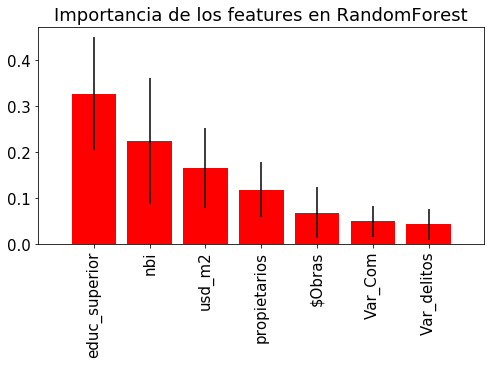

In [124]:
indices = np.argsort(importancias)[::-1]
nombres_features = X.columns

# Graficar la importancia de los features en el random forest
plt.figure(figsize=(8,4))
plt.title("Importancia de los features en RandomForest")
plt.bar(range(X.shape[1]), importancias[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), nombres_features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.rcParams.update({'font.size': 15})
plt.show()

In [51]:
gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gsrf.fit(X_train, y_train)
print (gsrf.best_params_)
print (gsrf.best_score_)

all_models['gsrf'] = {'model': gsrf.best_estimator_,
                      'score': evaluate_model(gsrf.best_estimator_)}

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 50}
0.8879310344827587
[[ 5  1]
 [ 2 43]]
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.98      0.96      0.97        45

    accuracy                           0.94        51
   macro avg       0.85      0.89      0.87        51
weighted avg       0.95      0.94      0.94        51



### ExtraTrees

In [52]:
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

all_models['et'] = {'model': et,
                    'score': evaluate_model(et)}

et.fit(X_train, y_train)

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 4  2]
 [ 4 41]]
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.95      0.91      0.93        45

    accuracy                           0.88        51
   macro avg       0.73      0.79      0.75        51
weighted avg       0.90      0.88      0.89        51



ExtraTreesClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [53]:
importancias = et.feature_importances_
std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)

In [54]:
indices = np.argsort(importancias)[::-1]
nombres_features = X.columns

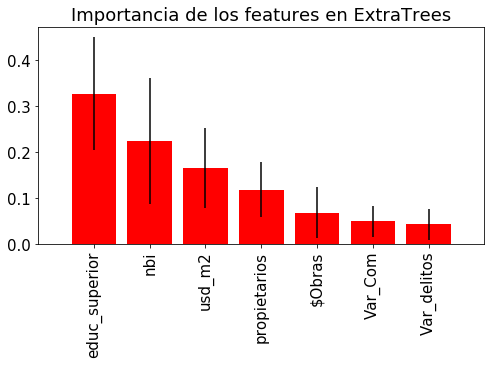

In [123]:
# Graficar la importancia de los features
plt.figure(figsize=(8,4))
plt.title("Importancia de los features en ExtraTrees")
plt.bar(range(X_train.shape[1]), importancias[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), nombres_features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.rcParams.update({'font.size': 15})
plt.show()

In [56]:
gset = GridSearchCV(ExtraTreesClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gset.fit(X_train, y_train)
print (gset.best_params_)
print (gset.best_score_)

all_models['gset'] = {'model': gset.best_estimator_,
                      'score': evaluate_model(gset.best_estimator_)}

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 5}
0.8879310344827587
[[ 3  3]
 [ 1 44]]
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.94      0.98      0.96        45

    accuracy                           0.92        51
   macro avg       0.84      0.74      0.78        51
weighted avg       0.91      0.92      0.91        51



## KNN

In [57]:
a = evaluate_model(KNeighborsClassifier())

[[ 2  4]
 [ 4 41]]
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         6
           1       0.91      0.91      0.91        45

    accuracy                           0.84        51
   macro avg       0.62      0.62      0.62        51
weighted avg       0.84      0.84      0.84        51



In [58]:
params = {'n_neighbors': range(2,60)}
gsknn = GridSearchCV(KNeighborsClassifier(),params, n_jobs=-1,cv=KFold(n_splits=3, shuffle=True))

In [59]:
gsknn.fit(X_train, y_train)

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1, param_grid={'n_neighbors': range(2, 60)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [60]:
gsknn.best_params_

{'n_neighbors': 9}

In [61]:
gsknn.best_score_

0.75

In [62]:
evaluate_model(gsknn.best_estimator_)

[[ 1  5]
 [ 1 44]]
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.90      0.98      0.94        45

    accuracy                           0.88        51
   macro avg       0.70      0.57      0.59        51
weighted avg       0.85      0.88      0.86        51



0.8823529411764706

In [63]:
all_models['knn'] = {'model': gsknn.best_estimator_,
                     'score': gsknn.best_score_}

### Bagging + KNN

In [64]:
baggingknn = BaggingClassifier(KNeighborsClassifier())

In [65]:
evaluate_model(baggingknn)

[[ 2  4]
 [ 3 42]]
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.91      0.93      0.92        45

    accuracy                           0.86        51
   macro avg       0.66      0.63      0.64        51
weighted avg       0.85      0.86      0.86        51



0.8627450980392157

In [66]:
bagging_params = {'n_estimators': [50, 100],
                  'max_samples': [0.7, 1.0],
                  'max_features': [0.1, 1.0],
                  'bootstrap_features': [True, False]}


gsbaggingknn = GridSearchCV(baggingknn,
                            bagging_params, n_jobs=-1,
                            cv=KFold(n_splits=3, shuffle=True))

In [67]:
gsbaggingknn.fit(X_train, y_train)

C:\Users\martin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto',
                                                                             leaf_size=30,
                                                                             metric='minkowski',
                                                                             metric_params=None,
                                                                             n_jobs=None,
                                                                             n_neighbors=5,
                                                                             p=2,
                                                                             weights='uniform'),
                                         bootstrap=True,
                                         bootstrap_features=False,
                     

In [68]:
gsbaggingknn.best_params_

{'bootstrap_features': True,
 'max_features': 0.1,
 'max_samples': 1.0,
 'n_estimators': 50}

In [69]:
all_models['gsbaggingknn'] = {'model': gsbaggingknn.best_estimator_,
                              'score': evaluate_model(gsbaggingknn.best_estimator_)}

[[ 0  6]
 [ 0 45]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.88      1.00      0.94        45

    accuracy                           0.88        51
   macro avg       0.44      0.50      0.47        51
weighted avg       0.78      0.88      0.83        51



C:\Users\martin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Comparación de modelos

,score
model,
gsrf,0.94
gset,0.92
rf,0.90
et,0.88
gsbaggingknn,0.88
knn,0.75


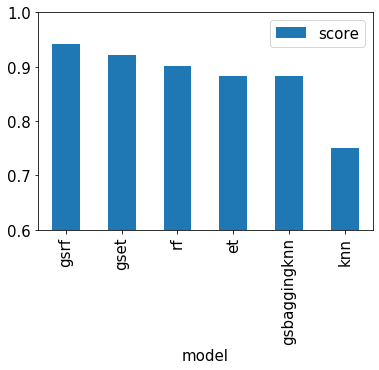

In [103]:
scores = pd.DataFrame([(k, v['score']) for k, v in all_models.items()],
             columns=['model', 'score']).set_index('model').sort_values('score', ascending=False)

plt.rcParams.update({'font.size': 15})

scores.plot(kind='bar')
plt.ylim(0.6, 1)

scores

In [82]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def retest(model):
    scores = cross_val_score(model, X_train, y_train,
                             cv=StratifiedKFold(n_splits=3, shuffle=True),
                             n_jobs=-1)
    m = scores.mean()
    s = scores.std()
    
    return m, s

for k, v in all_models.items():
    cvres = retest(v['model'])
    print (k), 
    all_models[k]['cvres'] = cvres

rf
gsrf
et
gset
knn
gsbaggingknn


,score,error
model,,
gset,0.91,0.01
gsrf,0.89,0.03
et,0.87,0.06
rf,0.85,0.05
gsbaggingknn,0.83,0.02
knn,0.76,0.01


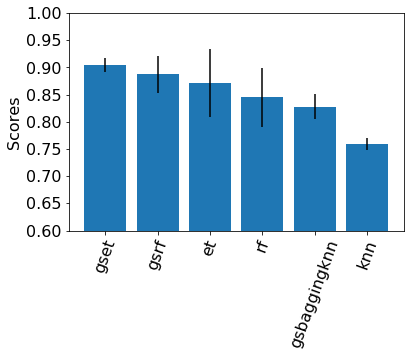

In [117]:
cvscores = pd.DataFrame([(k, v['cvres'][0], v['cvres'][1] ) for k, v in all_models.items()],
                        columns=['model', 'score', 'error']).set_index('model').sort_values('score', ascending=False)


fig, ax = plt.subplots()
rects1 = ax.bar(range(len(cvscores)), cvscores.score,
                yerr=cvscores.error,
                tick_label=cvscores.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=70)
plt.ylim(0.6, 1)
plt.rcParams.update({'font.size': 13})

cvscores
